In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score, precision_score, recall_score, f1_score
import joblib



Transformed data saved to /content/drive/MyDrive/transformed_property_data.csv


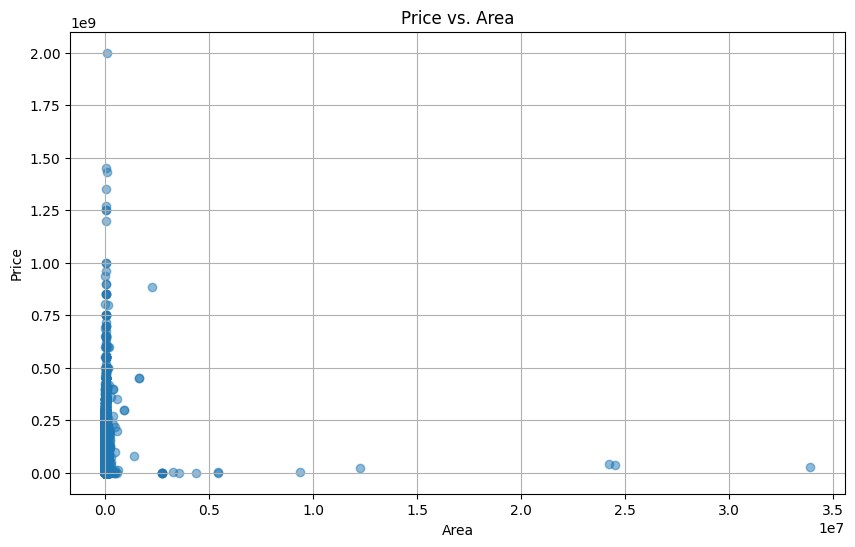

In [175]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



# Function to convert area values to square feet
def convert_to_square_feet(area_value):
    if pd.isnull(area_value):
        return np.nan  # Return NaN if area_value is null
    # Remove commas and extra spaces
    area_value = area_value.replace(',', '').strip()
    if 'Kanal' in area_value:
        # Convert kanal to square feet (1 kanal = 20 marla = 5445 square feet)
        return float(area_value.replace('Kanal', '')) * 5445
    elif 'Marla' in area_value:
        # Convert marla to square feet (1 marla = 272.25 square feet)
        return float(area_value.replace('Marla', '')) * 272.25
    else:
        # If no unit is specified, assume it's already in square feet
        return float(area_value)

# File path to the CSV data
file_path = '/content/drive/MyDrive/zameen-property-data.csv'

# Read the CSV into a DataFrame
df = pd.read_csv(file_path)

# Drop duplicates
df.drop_duplicates(inplace=True)

# Drop rows with missing values in specified columns
df.dropna(subset=['price', 'location', 'city', 'province_name', 'latitude', 'longitude', 'area', 'purpose', 'bedrooms'], inplace=True)

# Fill missing values with median for 'baths' and 'Unknown' for 'agency' and 'agent'
df.fillna({'baths': df['baths'].median(), 'agency': 'Unknown', 'agent': 'Unknown'}, inplace=True)


# Assign numeric values to property types
property_type_mapping = {
    'Farm House': 0,
    'Flat': 1,
    'House': 2,
    'Lower Portion': 3,
    'Penthouse': 4,
    'Room': 5,
    'Upper Portion': 6
}
df['property_type'] = df['property_type'].map(property_type_mapping)

# Convert data types
df['price'] = df['price'].astype(np.float32)
df['latitude'] = df['latitude'].astype(np.float32)
df['longitude'] = df['longitude'].astype(np.float32)
df['baths'] = df['baths'].astype(np.int8)
df['bedrooms'] = df['bedrooms'].astype(np.int8)

# Extract numerical value from 'area', convert to square feet, and combine
df['area'] = df['area'].apply(lambda x: convert_to_square_feet(x) if pd.notnull(x) else np.nan).astype(np.float32)

# Convert 'date_added' to datetime
df['date_added'] = pd.to_datetime(df['date_added'])

# Convert 'date_added' to ordinal
df['date_added'] = df['date_added'].map(pd.Timestamp.toordinal)



# Drop unnecessary columns
unnecessary_columns = ['province_name', 'purpose', 'agency', 'agent', 'page_url', 'location', 'city', 'property_id', 'location_id']
df.drop(columns=unnecessary_columns, inplace=True)


# Output path for the transformed data
output_path_csv = '/content/drive/MyDrive/transformed_property_data.csv'

# Save the transformed data to a CSV file without compression
df.to_csv(output_path_csv, index=False)
print(f"Transformed data saved to {output_path_csv}")

# Visualize the relationship between price and area
plt.figure(figsize=(10, 6))
plt.scatter(df['area'], df['price'], alpha=0.5)
plt.title('Price vs. Area')
plt.xlabel('Area')
plt.ylabel('Price')
plt.grid(True)
plt.show()


In [176]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load the transformed property data
transformed_data_path = '/content/drive/MyDrive/transformed_property_data.csv'
df = pd.read_csv(transformed_data_path)

# Define features (X) and target variable (y)
X = df.drop(columns=['price'])
y = df['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the decision tree regressor
model = DecisionTreeRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the testing set
y_pred = model.predict(X_test)

# Calculate root mean squared error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) score:", r2)

# Save the trained model
model_path = '/content/decision_tree_model.joblib'
joblib.dump(model, model_path)
print("Trained model saved to:", model_path)


Root Mean Squared Error (RMSE): 25011860.84651548
R-squared (R2) score: 0.46028569187817137
Trained model saved to: /content/decision_tree_model.joblib


In [190]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from datetime import datetime
import joblib

# Load the trained model
model_path = '/content/decision_tree_model.joblib'  # Specify the path to your trained model
model = joblib.load(model_path)

# Function to convert area values to square feet
def convert_to_square_feet(area_value):
    if 'kanal' in area_value:
        return float(area_value.replace('kanal', '')) * 5445
    elif 'marla' in area_value:
        return float(area_value.replace('marla', '')) * 272.25
    else:
        return float(area_value)

# Function to preprocess user input
def preprocess_input(user_input):
    user_input['latitude'] = float(user_input['latitude'])
    user_input['longitude'] = float(user_input['longitude'])
    user_input['baths'] = int(user_input['baths'])
    user_input['area'] = convert_to_square_feet(user_input['area'])
    user_input['bedrooms'] = int(user_input['bedrooms'])
    user_input['date_added'] = datetime.strptime(user_input['date_added'], '%Y-%m-%d').toordinal()
    return user_input

# Define static input values
static_input = {
    'property_type': 2,
    'latitude': 31.60337,
    'longitude': 74.33013,
    'baths': 1,
    'area': '4 marla',
    'bedrooms': 1,
    'date_added': '2019-03-07'
}

# Preprocess static input
preprocessed_input = preprocess_input(static_input)

# Convert to DataFrame with correct feature order
input_df = pd.DataFrame([preprocessed_input])

# Ensure columns are in the correct order
input_df = input_df[['property_type', 'latitude', 'longitude', 'baths', 'area', 'bedrooms', 'date_added']]

# Predict price using the trained model
predicted_price = model.predict(input_df)[0]
print("Predicted price:", predicted_price)


Predicted price: 5500000.0
